<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/kernels_svm_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mnist
!pip install jax jaxlib --upgrade

Requirement already up-to-date: jax in /usr/local/lib/python3.6/dist-packages (0.2.5)
Requirement already up-to-date: jaxlib in /usr/local/lib/python3.6/dist-packages (0.1.56+cuda101)


In [ ]:
import pathlib
import random
import pandas as pd
import matplotlib.pyplot as plt
import mnist
import sklearn
from sklearn import svm
import jax.numpy as jnp
import functools
import copy
import numpy as np
import requests
import pickle

from scipy.ndimage import interpolation
from jax import random
from jax.experimental import optimizers, stax
from jax.api import jit, grad, vmap

In [ ]:
TMP_DIR = "./tmp/"
MN_TRAIN_SPLIT = 1000
MN_TEST_SPLIT = 200
SAMPLE_IDX = 0
CF10_SPLIT = 80000
CF10_TRAIN_SPLIT = 1000
CF10_TEST_SPLIT = 200

In [ ]:
pathlib.Path(TMP_DIR).mkdir(parents=True, exist_ok=True)
mnd = {}

mnd["train_x"] = mnist.download_and_parse_mnist_file(
  "train-images-idx3-ubyte.gz",
  target_dir=TMP_DIR
)
mnd["train_y"] = mnist.download_and_parse_mnist_file(
  "train-labels-idx1-ubyte.gz",
  target_dir=TMP_DIR
)
mnd["test_x"] = mnist.download_and_parse_mnist_file(
  "t10k-images-idx3-ubyte.gz",
  target_dir=TMP_DIR
)
mnd["test_y"] = mnist.download_and_parse_mnist_file(
  "t10k-labels-idx1-ubyte.gz",
  target_dir=TMP_DIR
)

train_x.shape: (60000, 784)
train_y.shape: (60000,)
test_x.shape: (10000, 784)
test_y.shape: (10000,)
train_x[0] is 5.


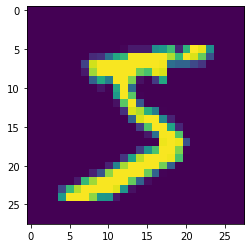

In [ ]:
def prep_data(data):
  data["orig_dim"] = data["train_x"].shape[1]

  data["train_x"] = data["train_x"].reshape((data["train_x"].shape[0], -1))
  data["test_x"] = data["test_x"].reshape((data["test_x"].shape[0], -1))
  print("train_x.shape:", data["train_x"].shape)
  print("train_y.shape:", data["train_y"].shape)
  print("test_x.shape:", data["test_x"].shape)
  print("test_y.shape:", data["test_y"].shape)

  print("train_x[{}] is {}.".format(SAMPLE_IDX, data["train_y"][SAMPLE_IDX]))
  plt.imshow(data["train_x"][SAMPLE_IDX].reshape((data["orig_dim"], -1)))
  plt.show()
prep_data(mnd)

In [ ]:
clf_rbf = svm.SVC(verbose=True)
clf_rbf.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT])

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

Truth//pred: 7//7


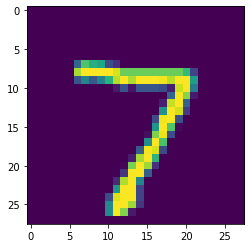

rbf test error: 0.06999999999999995


In [ ]:
def clf_data_pred(clf, data, idx):
  return clf.predict([data["test_x"][idx]])[0]

def clf_data_pred_plot(clf, data, idx):
  pred = clf_data_pred(clf, data, idx)
  print("Truth//pred: {}//{}".format(data["test_y"][idx], pred))
  plt.imshow(data["test_x"][idx].reshape((28, -1)))
  plt.show()

def clf_data_acc(clf, data, test_split):
  return np.count_nonzero(
    data["test_y"][:test_split] == clf.predict(data["test_x"][:test_split])) / \
    len(data["test_x"][:test_split])

clf_data_pred_plot(clf_rbf, mnd, 0)
print("rbf test error: {}".format(1 - clf_data_acc(clf_rbf, mnd, MN_TEST_SPLIT)))

In [ ]:
clf_poly_4 = svm.SVC(verbose=True, kernel="poly", degree=4)
print(clf_poly_4.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("poly_4 test error: {}".format(1 - clf_data_acc(clf_poly_4, mnd, MN_TEST_SPLIT)))

[LibSVM]SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
poly_4 test error: 0.20499999999999996


train_x[0] is 5.
Original:


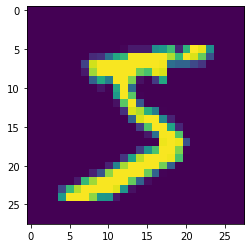

Deskewed:


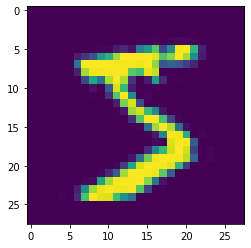

In [ ]:
def img_moments(image):
  c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
  totalImage = np.sum(image) #sum of pixels
  m0 = np.sum(c0*image)/totalImage #mu_x
  m1 = np.sum(c1*image)/totalImage #mu_y
  m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
  m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
  m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
  mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
  covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
  return mu_vector, covariance_matrix

def deskew_img(image):
  c,v = img_moments(image)
  alpha = v[0,1]/v[0,0]
  affine = np.array([[1,0],[alpha,1]])
  ocenter = np.array(image.shape)/2.0
  offset = c-np.dot(affine,ocenter)
  img = interpolation.affine_transform(image,affine,offset=offset)
  return (img - img.min()) / (img.max() - img.min())

def deskew_data(data):
  ds = copy.deepcopy(data)
  ds["train_x"] = [deskew_img(img.reshape((ds["orig_dim"], -1))).reshape((-1,))
    for img in ds["train_x"]]
  ds["test_x"] = [deskew_img(img.reshape((ds["orig_dim"], -1))).reshape((-1,))
    for img in ds["test_x"]]

  print("train_x[{}] is {}.".format(SAMPLE_IDX, data["train_y"][SAMPLE_IDX]))
  print("Original:")
  plt.imshow(data["train_x"][SAMPLE_IDX].reshape((data["orig_dim"], -1)))
  plt.show()
  print("Deskewed:")
  plt.imshow(ds["train_x"][SAMPLE_IDX].reshape((ds["orig_dim"], -1)))
  plt.show()
  return ds

mndds = deskew_data(mnd)

In [ ]:
clf_poly_4_ds = svm.SVC(verbose=True, kernel="poly", degree=4)
print(clf_poly_4_ds.fit(mndds["train_x"][:MN_TRAIN_SPLIT], mndds["train_y"][:MN_TRAIN_SPLIT]))
print("poly_4_ds test error: {}".format(1 - clf_data_acc(clf_poly_4_ds, mndds, MN_TEST_SPLIT)))

[LibSVM]SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
poly_4_ds test error: 0.08499999999999996


In [ ]:
def laplacian_kernel(A, B):

clf_laplacian_ = svm.SVC(verbose=True, kernel=laplacian_kernel)
print(clf_poly_4_ds.fit(mndds["train_x"][:MN_TRAIN_SPLIT], mndds["train_y"][:MN_TRAIN_SPLIT]))
print("poly_4_ds test error: {}".format(1 - clf_data_acc(clf_poly_4_ds, mndds, MN_TEST_SPLIT)))

In [ ]:
open(TMP_DIR + "cifar-100-python.tar.gz", "wb").write(requests.get(
  "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz",
  allow_redirects=True).content)
cf10r = pickle.load(open(TMP_DIR + "cifar-100-python.tar.gz", "rb"), encoding="bytes")
cf10d = {}

cf10d["names"] = cf10r["label_names"]
cf10d["train_x"] = cf10r["data"][:CF10_SPLIT]
cf10d["train_y"] = cf10r["labels"][:CF10_SPLIT]
cf10d["test_x"] = cf10r["data"][CF10_SPLIT:]
cf10d["test_y"] = cf10r["labels"][CF10_SPLIT:]

UnpicklingError: ignored

In [ ]:
clf_cf10_rbf = svm.SVC(verbose=True)
clf_cf10_rbf.fit(cf10d["train_x"][:CF10_TRAIN_SPLIT], cf10d["train_y"][:CF10_TRAIN_SPLIT])